In [14]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [15]:
actions = ['hand_waving', 'clap', 'head_waving']

data = np.concatenate([
    np.load('dataset/seq_hand_waving_1680678849.npy'),
    np.load('dataset/seq_clap_1680678849.npy'),
    np.load('dataset/seq_head_waving_1680678849.npy'),
], axis=0)

data.shape

(630, 30, 148)

In [16]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(630, 30, 147)
(630,)


In [17]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(630, 4)

In [18]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(567, 30, 147) (567, 4)
(63, 30, 147) (63, 4)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                54272     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 56,484
Trainable params: 56,484
Non-trainable params: 0
_________________________________________________________________


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=1000,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/1000
17/18 [===========================>..] - ETA: 0s - loss: 0.6809 - acc: 0.6985
Epoch 1: val_acc improved from -inf to 0.66667, saving model to models/model.h5
18/18 [==============================] - 0s 15ms/step - loss: 0.6784 - acc: 0.6984 - val_loss: 0.7071 - val_acc: 0.6667 - lr: 1.2207e-07
Epoch 2/1000
13/18 [====================>.........] - ETA: 0s - loss: 0.6934 - acc: 0.6947
Epoch 2: val_acc did not improve from 0.66667
18/18 [==============================] - 0s 11ms/step - loss: 0.6784 - acc: 0.6966 - val_loss: 0.7073 - val_acc: 0.6667 - lr: 1.2207e-07
Epoch 3/1000
18/18 [==============================] - ETA: 0s - loss: 0.6783 - acc: 0.6949
Epoch 3: val_acc did not improve from 0.66667
18/18 [==============================] - 0s 11ms/step - loss: 0.6783 - acc: 0.6949 - val_loss: 0.7073 - val_acc: 0.6667 - lr: 1.2207e-07
Epoch 4/1000
13/18 [====================>.........] - ETA: 0s - loss: 0.6572 - acc: 0.7115
Epoch 4: val_acc did not improve from 0.66667
18/18 [

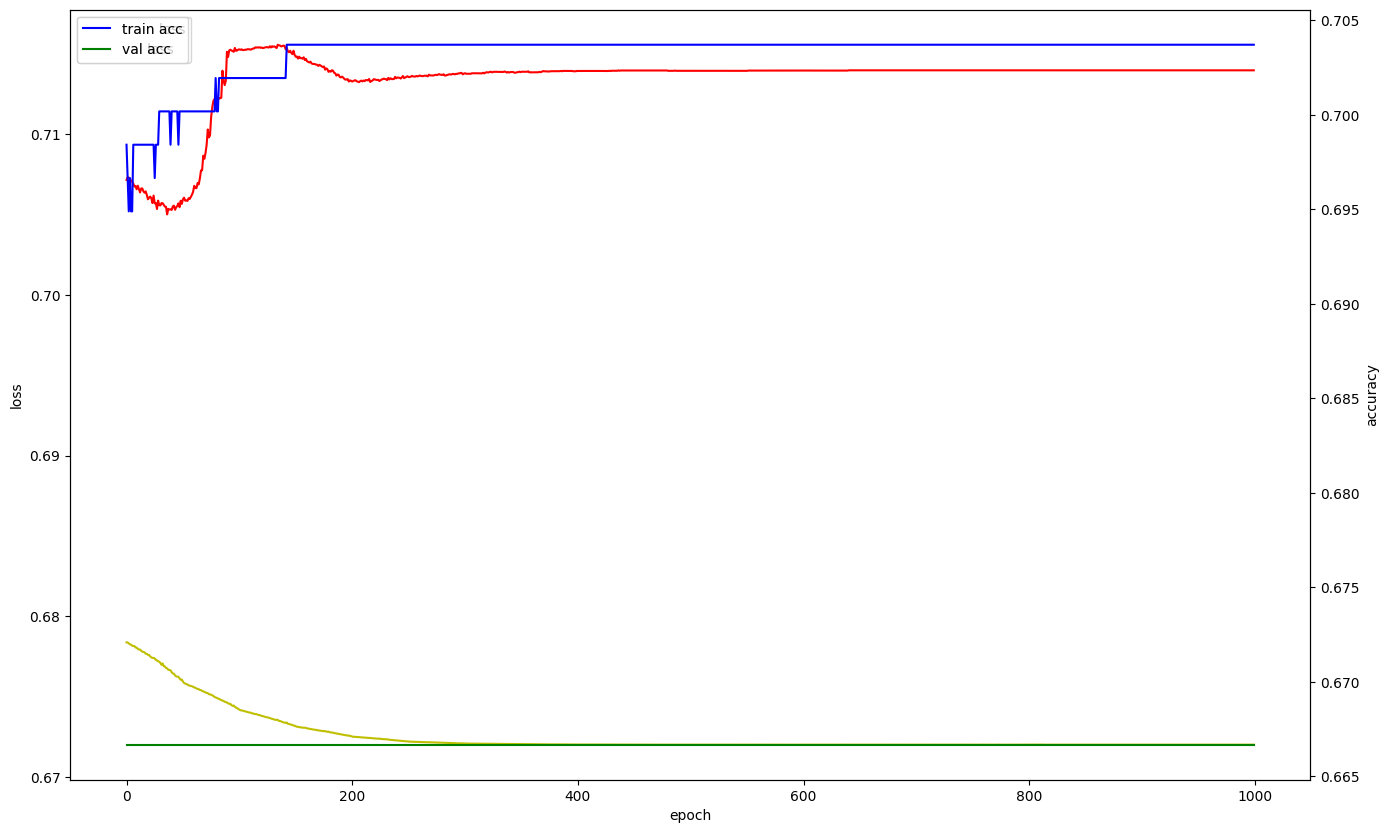

In [33]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [34]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

2/2 [==============================] - 0s 5ms/step


array([[[44,  6],
        [ 6,  7]],

       [[39,  4],
        [11,  9]],

       [[45,  3],
        [ 0, 15]],

       [[40,  8],
        [ 4, 11]]])